In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
import fssa
from scipy.optimize import curve_fit
from scipy import stats as st
%matplotlib inline


In [2]:
#Paso el MonteCarlo por numba para que vaya mas rapido
@jit
def proceso(N, T, l, x0, dens):
    x = np.zeros((T+1, N))
    xt = x0
    x[0][:] = x0[:]
    for i in range(0, T + 1):
        for j in range(N+1):
            k = np.random.randint(N)
            
            #El primero
            if (k == 0):
                p = np.random.uniform(0,1)
                if (xt[0] == 1):
                    if ((p*(l+1)) < 1):
                        xt[0] = 0
                    else:
                        q = np.random.random()
                        if (q < 0.5):
                            xt[N] = 1
                        else:
                            xt[1] = 1
            #El ultimo
            elif (k == N):
                p = np.random.uniform(0,1)
                if (xt[N] == 1):
                    if ((p*(l+1)) < 1):
                        xt[N] = 0
                    else:
                        q = np.random.random()
                        if (q < 0.5):
                            xt[N-1] = 1
                        else:
                            xt[0] = 1
            #el resto
            else:
                p = np.random.uniform(0,1)
                if (xt[k] == 1):
                    if ((p*(l+1)) < 1):
                        xt[k] = 0
                    else:
                        q = np.random.random()
                        if (q < 0.5):
                            xt[k-1] = 1
                        else:
                            xt[k+1] = 1
        #actualizo lattice
        x[i][:] = xt[:]
        dens[i] = xt.sum()
    
    return x, dens

# Representacion del CP

Indique la tasa de infeccion:
3.29355
Condicion inicial:
1)Lleno, 2) Semilla, 3) Aleatorio
2
0.01877367442630701


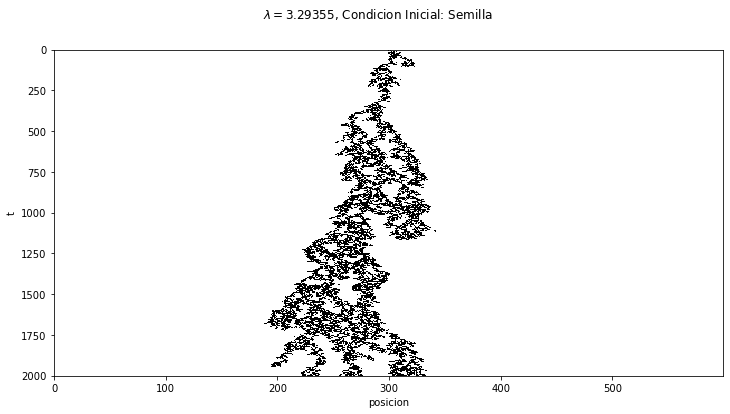

In [80]:
def CP(N, T):
    fig, fig1 = plt.subplots(1, 1, figsize=(12,6))
    X = np.zeros([T + 1, N])
    xt = np.zeros(N)
    dens = np.zeros(T + 1)
    t = np.linspace(0, T+1, T+1)
    tmax = len(t)
    
    #Preguntamos la probabilidad de enlace
    print(f'Indique la tasa de infeccion:')
    l = float(input())
    #CONDICION INICIAL
    #Preguntamos por la condicion inicial
    print(f'Condicion inicial:')
    print(f'1)Lleno, 2) Semilla, 3) Aleatorio')
    ci = int(input())
    
    if (ci == 1):
        #Full
        xt = np.ones(N )
        dens[0] = N
        plt.suptitle(f"$\lambda={l}$, Condicion Inicial: Lleno")
    
    elif(ci == 2):
        #Semilla
        xt[(N // 2)] = 1
        dens[0] = 1
        plt.suptitle(f"$\lambda={l}$, Condicion Inicial: Semilla")
       

        
    elif(ci == 3):
        #ALEATORIA
        for i in range(N):
            r = np.random.random()
            if (r > 0.5):
                xt[i] = 1
                dens[0] += 1
        plt.suptitle(f"$\lambda={l}$, Condicion Inicial: Aleatorio")
    
    #HAGO LAS ITERACIONES
    np.random.seed()
    
    S = proceso(N, T, l, xt, dens)
    X = S[0]
    dens = S[1]
    
    #veamos el estado estacionario
    rhoest = dens[(T-500):T:20] / (N+1)
    
    std = rhoest.std()
            
    print(std)
        
    #DIBUJO EL RESULTADO        
    fig1.imshow(X, interpolation='nearest', cmap=cm.binary,aspect="auto")
    fig1.set_xlabel('posicion')
    fig1.set_ylabel('t')
    fig1.set_ylim(tmax,0)
    #plt.savefig('avalancha_seed.PNG')
    
CP(600,2000)

# Diagrama de fases

In [29]:
def serie(N, T, dlamda, trials):
    #definiciones
    prob = np.linspace(3.29,3.30,dlamda)
    rhoest = np.zeros(dlamda)
    stdest = np.zeros(dlamda)
    X = np.zeros((T+1, N))
    var = np.zeros(dlamda)

    
    #HAGO LAS ITERACIONES
    print('Comienzo la serie de experimentos')
    for m in range(dlamda):
        #avisos
        if (m == (dlamda//4)): 
            print('25%')
        if (m == (dlamda//2)): 
            print('50%')
        if (m == ((3 * dlamda)//4)): 
            print('75%')
        if (m == (dlamda-10)):
            print('Acabando experimentos')
        
        l = prob[m]
        rhotrial = np.zeros(trials)
        stdtrial = np.zeros(trials)
        vartrial = np.zeros(trials)
        for i in range(1, trials + 1, 1):
            #Condicion inicial (full)
            dens = np.zeros(T + 1)
            xt = np.ones(N)
            #xt[N//2] = 1
            dens[0] = xt.sum()
            
            #empiezo el CP
            np.random.seed()
            S = proceso(N, T, l, xt, dens)
            X += S[0]
            dens = S[1]
        
            #densidad estacionaria
            rho1 = dens[(T//2):T:10] / (len(xt))
            rhotrial[i-1] = rho1.mean()
            stdtrial[i-1] = rho1.std()
            vartrial[i-1] = rho1.var()
            
        X = X / trials

        #me quedo solo con los que sobreviven
        #rhotrial = rhotrial[rhotrial>0]
        #stdtrial = stdtrial[rhotrial>0]
        
        #promedio sobre la serie de intentos
        
        rhoest[m] = rhotrial.mean()
        stdest[m] = stdtrial.mean()
        var[m] = N * vartrial.mean()
    
    return rhoest, prob, stdest, X, var
Datos = serie(2000,20000,100,100)

Comienzo la serie de experimentos


KeyboardInterrupt: 

[3.24137931 3.37931034 3.51724138 3.65517241 3.79310345 3.93103448
 4.06896552 4.20689655 4.34482759 4.48275862 4.62068966 4.75862069
 4.89655172 5.03448276 5.17241379 5.31034483 5.44827586 5.5862069
 5.72413793 5.86206897 6.        ]


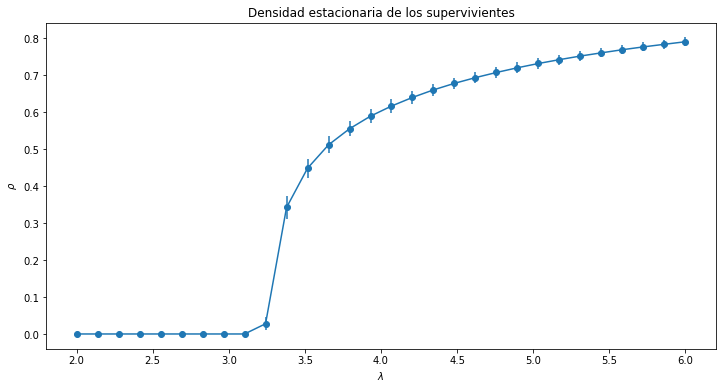

In [7]:
def fases(rho, lamda, std):
    print(lamda[rho>0])
    #diagrama de fases

    fig, (fig3) = plt.subplots(1,1, figsize=(12,6))
    fig3.errorbar(lamda, rho, yerr= std, fmt='o-')
    #fig3.set_xscale('log')
    #fig3.set_yscale('log')
    #fig3.set_xlim(3,5)
    fig3.set_xlabel(r'$\lambda$')
    fig3.set_ylabel(r'$\rho$')
    fig3.set_title('Densidad estacionaria de los supervivientes')
    
    #fig1.plot(lamda, std)
    #fig1.set_title('Desviación estandar de cada densidad estacionaria')
    #plt.savefig('diagrama_fases_1.PNG')

fases(Datos[0], Datos[1], Datos[2])

# Correlaciones

In [10]:
@jit
def correlacion(cr, N, T, X):
    for i in range(0,N): 
        cnt = np.zeros(T//2)
        for j in range(T//2,T):
            cnt[j - (T//2)] = (X[j][i] * X[j][0])
    
        cr[i] = cnt.mean()
    return cr

In [25]:
def corr(N, T, prob, trials):
    
    X = np.zeros((T+1, N))
    cr = np.zeros(N)
    rhotrial = np.zeros(trials)
    stdtrial = np.zeros(trials)
    #hago las series sobre un l fijo
    for i in range(1, trials + 1, 1):
        c = np.zeros(N)
        #Condicion inicial (full)
        dens = np.zeros(T + 1)
        xt = np.zeros(N)
        xt[0] = 1
        dens[0] = N
            
        #empiezo el CP
        np.random.seed()
        S = proceso(N, T, prob, xt, dens)
        X = S[0]
        dens = S[1]
        
        #densidad estacionaria
        rho1 = dens[(T//2):T:10] / N
        rhotrial[i-1] = rho1.mean()
        stdtrial[i-1] = rho1.std()
        
        #correlacion espacial
        c = correlacion(c, N, T, X)
        
        cr += c
    cr = cr / trials
            
    #promedio sobre toda la serie
    rhoest = rhotrial.mean()
    stdest = stdtrial.mean()
    cr = (cr - np.power(rhoest,2))
    print(cr, rhoest)
    
    return cr
#CORRT = corr(2000, 20000, 3.29, 10)

3.297
[ 5.39770366e-04  4.13570366e-04  3.69370366e-04 ... -1.02963435e-06
 -1.02963435e-06 -1.02963435e-06] 0.001014709
3.300666666666667
[ 8.78662902e-04  6.94862902e-04  6.20062902e-04 ... -7.37097800e-07
 -7.37097800e-07 -7.37097800e-07] 0.0008585439999999999
3.3043333333333336
[ 6.41520974e-04  5.06120974e-04  4.48520974e-04 ... -1.07902649e-06
 -1.07902649e-06 -1.07902649e-06] 0.001038762
3.3080000000000003
[ 8.43542791e-04  6.60542791e-04  5.77742791e-04 ... -2.85720875e-06
 -2.85720875e-06 -2.85720875e-06] 0.001690328
3.311666666666667
[ 7.58858057e-04  5.89858057e-04  5.12458057e-04 ... -1.74194331e-06
 -1.74194331e-06 -1.74194331e-06] 0.001319827
3.3153333333333332
[ 1.20761361e-03  9.23613607e-04  8.17613607e-04 ... -8.38639319e-06
 -8.38639319e-06 -8.38639319e-06] 0.002895927
3.319
[ 1.54494981e-03  1.18714981e-03  1.05574981e-03 ... -5.45018907e-06
 -5.45018907e-06 -5.45018907e-06] 0.0023345640000000003
3.3226666666666667
[ 8.47364241e-04  6.73164241e-04  5.86564241e-04 ..

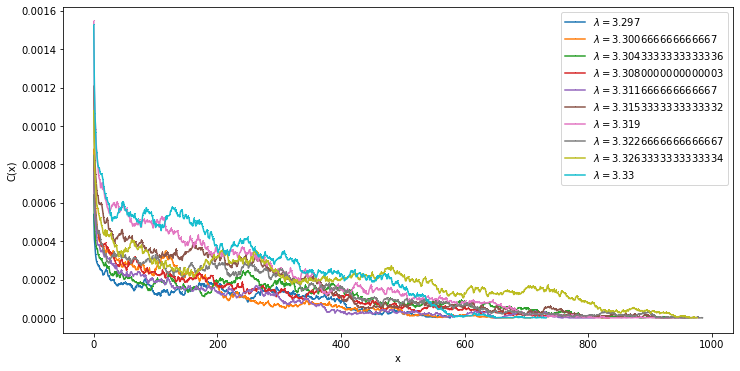

In [62]:
def plotcore(N, T, figx=None):
    
    prob = np.linspace(3.297, 3.33, 10)
    cr = np.zeros([len(prob), N])
    #Funcion de correlacion espacial para un rango de l
    for l in range(len(prob)):
        print(prob[l])
        c = corr(N, T, prob[l], 500)
        r = np.linspace(0,N,N)    
        figx.plot(r[c>0], c[c>0], ',-', label=(f'$\lambda={prob[l]}$'))
        
        #guardo el resultado
        cr[l][:] = c[:]
        
    #figx.set_xlim(1500, 2000)
    #figx.set_xscale('log')
    #figx.set_yscale('log')
    figx.set_xlabel('x')
    figx.set_ylabel('C(x)')
    figx.legend()
    
    return prob, cr

fig, fig10 = plt.subplots(1, 1, figsize=(12,6))
CR = plotcore(2000, 20000, figx=fig10)

In [63]:
#ajuste al decaimiento exponencial de la funcion de correlacion
def corfit(x, a, b):
    
    return a * np.exp(-x / b)

In [64]:
#ajuste del power law de la longitud de correlacion
def xifit(x, a, b, c):
    return a / np.power(x - c, b)

[28.38333642  1.05        3.2       ] [[ 1.06096790e+06 -3.13103286e+04  3.31010178e+03]
 [-3.13103286e+04  9.25121293e+02 -9.79424251e+01]
 [ 3.31010178e+03 -9.79424251e+01  1.03866327e+01]]


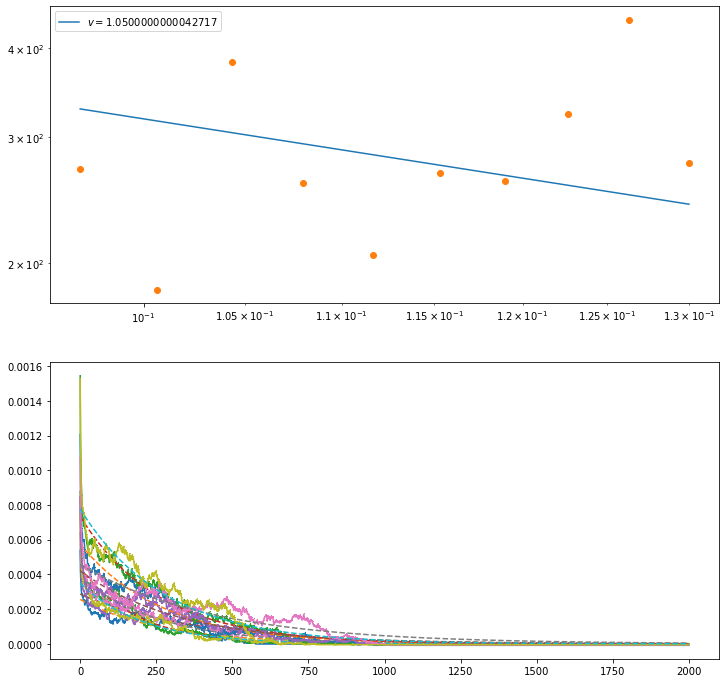

In [65]:
def fitesp(cr, prob, N, figx=None, figy=None):
    xfit = np.linspace(0, N, N)
    yfit = np.zeros(N)
    xi = np.zeros(len(prob))
    
    #calculo la longitud de correlacion para cada prob
    for i in range(len(prob)):
        yfit[:] = cr[i][:]
        
        fit, fitcov = curve_fit(corfit, xfit, yfit, bounds=([0, 0], [1, 2000]))
        
        xi[i] = fit[1]
        yf = corfit(xfit, fit[0], fit[1])
        
        figy.plot(xfit, yfit, ',-')
        figy.plot(xfit, yf, '--')
    

        
    #figx.plot(prob, xi, 'o-')

    #calculo el exponente crítico de la longitud de correlacion a partir del power law
    
    fit2, fitcov2 = curve_fit(xifit, prob, xi,  bounds=([0, 1.05, 3.2], [10000, 1.1, 3.3]), maxfev=1000)
    print(fit2, fitcov2)
    xif = xifit(prob, fit2[0], fit2[1], fit2[2])
    
    #plot del power law
    
    figx.plot(prob - fit2[2],xif, label=(f'$v ={fit2[1]}$') )
    figx.plot(prob - fit2[2], xi, 'o')
    figx.set_xscale('log')
    figx.set_yscale('log')
    figx.legend()
fig, (fig12, fig13) = plt.subplots(2, 1, figsize=(12, 12))

fitesp(CR[1], CR[0], 2000, figx=fig12, figy=fig13)

In [66]:
@jit
def corrte(c, tmin, T, N, X):

    for i in range(tmin,T):
        ct = np.zeros(N)
        for j in range(N):
            ct[j] = (X[i+1][j] * X[i][j])
        c[i-tmin] = ct.mean()
    
    return c

In [53]:
def cotemp(N, T, prob, trials):
    tmin = (T) // 2
    X = np.zeros((T+1, N))
    ct = np.zeros(tmin)
    rhotrial = np.zeros(trials)
    stdtrial = np.zeros(trials)
    #calculo el promedio de la correlacion temporal
    for i in range(1, trials + 1, 1):
        #Condicion inicial (full)
        dens = np.zeros(T + 1)
        xt = np.zeros(N)
        #xt[0] = 1
        dens[0] = N
            
        #empiezo el CP
        np.random.seed()
        S = proceso(N, T, prob, xt, dens)
        X = S[0]
        dens = S[1] / N
        
        #densidad estacionaria
        rho1 = dens[(T//2):T:10]
        rhotrial[i-1] = rho1.mean()
        stdtrial[i-1] = rho1.std()

        
        ct = corrte(ct, tmin, T, N, X)
    #promedio de la serie
            
    ct = ct / (trials)
            
    
    rhoest = rhotrial.mean()
    stdest = stdtrial.mean()
    
    #ct = ct - np.power(rhoest, 2)
        
    
    return ct
    

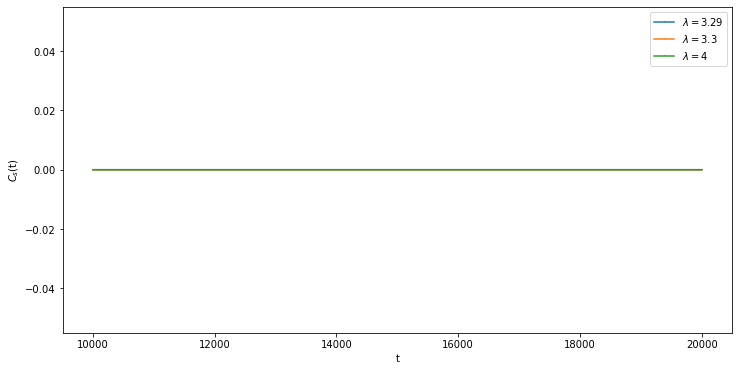

In [54]:
def plotcort(N, T, figx=None):
    tmin = (T) // 2
    for l in [3.29, 3.3,4]:
        c = cotemp(N, T, l, 5)
        t = np.linspace(tmin,T, tmin)    
        figx.plot(t, c, ',-', label=(f'$\lambda={l}$'))
        
    #figx.set_xscale('log')
    #figx.set_yscale('log')
    figx.set_xlabel('t')
    figx.set_ylabel(f'$C_s$(t)')
    figx.legend()

fig, fig10 = plt.subplots(1, 1, figsize=(12,6))
plotcort(2000, 20000, figx=fig10)

# Exponente beta

In [26]:
def rhopo(x, a, b, c):
    
    return a * np.power(x - c, b)

[0.17592646 0.18261008 0.19483784 0.20371269 0.21667927 0.22880269
 0.23875982 0.25172853 0.259859   0.26853253 0.27102853 0.28740065
 0.2890415  0.29887517 0.30122262 0.3133226  0.31895284 0.3233414
 0.33008887 0.33469755 0.33856122 0.34476572 0.35081858 0.35441542
 0.3580822  0.36426009 0.3676782  0.36947587 0.37288788 0.37741407
 0.38135357 0.3853235  0.38828345 0.39157207 0.39406896 0.39860206
 0.40267697 0.40400423 0.40678204 0.41046311 0.41332594 0.4164924
 0.41877729 0.42169422 0.4238614  0.42743954 0.42930095 0.43228471
 0.43382249 0.43645829 0.4396849 ]
[0.67372828 0.277      3.29355523] [[ 9.46191771e-05  7.12909772e-05 -6.51328472e-06]
 [ 7.12909772e-05  5.68431993e-05 -5.76779666e-06]
 [-6.51328472e-06 -5.76779666e-06  8.99040263e-07]]


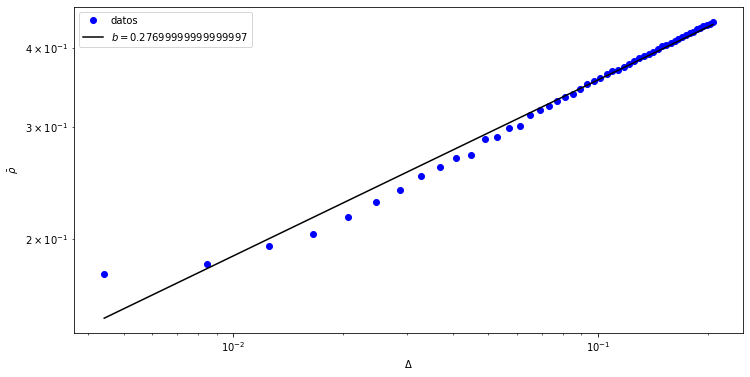

In [49]:
def power(x, y, std, figx=None):
    rho = x
    prob = y
    
    #selecciono los valores de rho a partir de los cuales el proceso sobrevive
    
    xf = prob[(prob>3.297)]
    yf = rho[(prob>3.297)]
    std = std[prob>3.297]
    
    print(yf)
    #print(yf)
    #obtengo el punto critico y el exponente beta a partir de power law
    
    fit, fitcov = curve_fit(rhopo, xf, yf, sigma=std, bounds=([0.5, 0.276, 3.293],[1, 0.277, 3.3]), maxfev=10000)
    dfit = fit[1]
    yfit = rhopo(xf, fit[0], fit[1], fit[2])
    print(fit, fitcov)
    
    #plot del resultado
    
    figx.errorbar(xf - fit[2], yf, yerr=std, fmt='ob', label=('datos'))
    figx.plot(xf - fit[2], yfit, 'k-', label=(f'$b={dfit}$'))
    figx.set_xscale('log')
    figx.set_yscale('log')
    figx.set_xlabel(f'$\Delta$')
    figx.set_ylabel(r'$\bar \rho$')
    figx.legend()
    
fig, fig6 = plt.subplots(1, 1, figsize=(12,6))
power(Datos[0], Datos[1], Datos[2], figx=fig6)

#plt.savefig('power.PNG')

# Exponente gamma

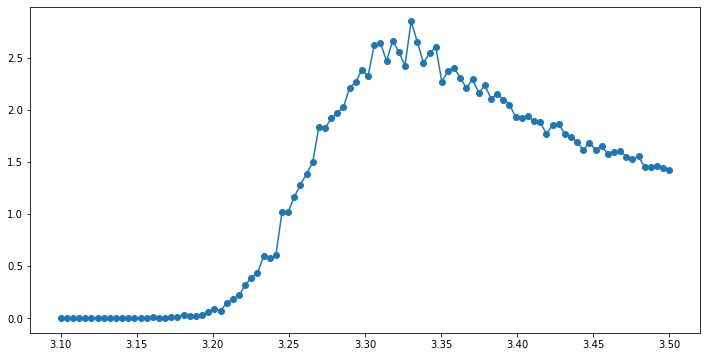

In [82]:
def plotvar(prob, var, N):    
    fig, fig1 = plt.subplots(1, 1, figsize=(12, 6))
    
    fig1.plot(prob, var, 'o-')

plotvar(Datos[1], Datos[4], 2000)

In [94]:
def varpow(x, a, b, c):
    return a / np.power(x - c, b)

[0.79814755 0.55       3.20214139] [[ 0.01881064 -0.02952959  0.00846735]
 [-0.02952959  0.04815884 -0.01419169]
 [ 0.00846735 -0.01419169  0.00426814]]


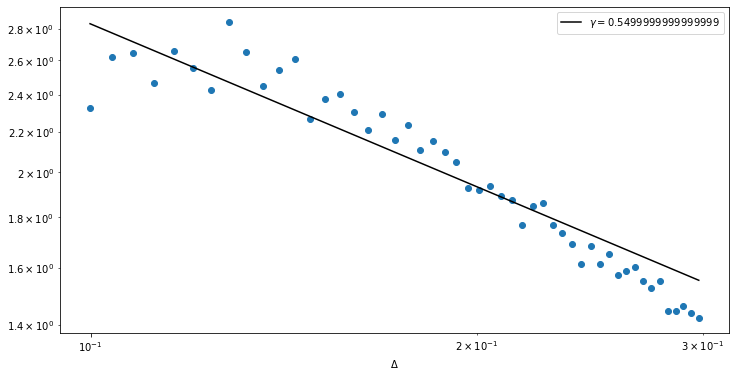

In [95]:
def gammapow(prob, var, figx=None):
    
    
    xfit = prob[prob>3.3]
    yfit = var[prob>3.3]
    
    fit, fitcov = curve_fit(varpow, xfit, yfit, bounds=([0, 0.5, 3.2], [1, 0.55, 3.3]), maxfev=10000)
    yf = varpow(xfit, fit[0], fit[1], fit[2])
    
    figx.plot(xfit - fit[2], yfit, 'o')
    figx.plot(xfit - fit[2], yf, '-k', label=(f'$\gamma ={fit[1]}$'))
    figx.set_xscale('log')
    figx.set_yscale('log')
    figx.set_xlabel(f'$\Delta$')
    fig
    figx.legend()
    plt.savefig('exponente_gamma.PNG')
    
    print(fit, fitcov)
fig, fig11 =plt.subplots(1, 1, figsize=(12, 6))

gammapow(Datos[1], Datos[4], figx=fig11)

# Diagrama de fase en funcion del tamaño del sistema

Comienzo la serie de experimentos para n=50
25%
Acabando experimentos
50%
75%
Comienzo la serie de experimentos para n=100
25%
Acabando experimentos
50%
75%
Comienzo la serie de experimentos para n=200
25%
Acabando experimentos
50%
75%
Comienzo la serie de experimentos para n=500
25%
Acabando experimentos
50%
75%
Comienzo la serie de experimentos para n=1000
25%
Acabando experimentos
50%
75%


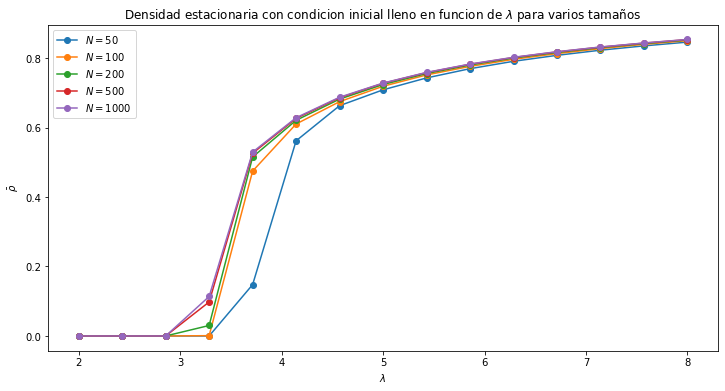

In [18]:
#densidad estacionaria frente a T
def serie2(T, dlamda, trials, figx=None):
    N = [50, 100, 200, 500, 1000]
    #hago intervalos de lambda
    prob = np.linspace(2, 8, dlamda)
    
    #guardo la rhoest de cada N
    rho = np.zeros([len(N), dlamda])

    
    rhoest = np.zeros(dlamda)
    stdest = np.zeros(dlamda)

        
    for j in range(len(N)):
        
        n = N[j]
        #HAGO LAS ITERACIONES
        print(f'Comienzo la serie de experimentos para n={n}')
        for m in range(dlamda):
            
            #avisos
            if (m == (dlamda//4)): 
                print('25%')
            if (m == (dlamda//2)): 
                print('50%')
            if (m == ((3 * dlamda)//4)): 
                print('75%')
            if (m == (dlamda-10)):
                print('Acabando experimentos')
        
            l = prob[m]
            rhotrial = np.zeros(trials)
            stdtrial = np.zeros(trials)
            for i in range(1, trials + 1, 1):
                #Condicion inicial (full)
                dens = np.zeros(T + 1)
                xt = np.ones(n)
                #xt[N//2] = 1
                dens[0] = xt.sum()
            
                #empiezo el CP
                np.random.seed()
                S = proceso(n, T, l, xt, dens)
                X = S[0]
                dens = S[1]
        
                #densidad estacionaria
                rho1 = dens[(T//2):T:10] / (len(xt))
                rhotrial[i-1] = rho1.mean()
                stdtrial[i-1] = rho1.std()
            
            #me quedo solo con los que sobreviven
            #rhotrial = rhotrial[rhotrial>0]
            #stdtrial = stdtrial[rhotrial>0]
            rhoest[m] = rhotrial.mean()
            stdest[m] = stdtrial.mean()
                
            rho[j][:] = rhoest[:]
            #plot        
        figx.errorbar(prob, rhoest, yerr=stdest, fmt='o-', label=(f'$N={n}$'))
        #figx.set_xscale('log')
        #figx.set_yscale('log')
        figx.set_xlabel(f'$\lambda$')
        figx.set_ylabel(r'$\bar \rho$')
        figx.set_title(f'Densidad estacionaria con condicion inicial lleno en funcion de $\lambda$ para varios tamaños')
    figx.legend()
    
    return rho, stdest, prob, N
    
fig, fig1 = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

SCA = serie2(20000, 15, 100, figx=fig1)

plt.savefig('rho_est_frente_lambda_y_n.PNG')

# Scaling

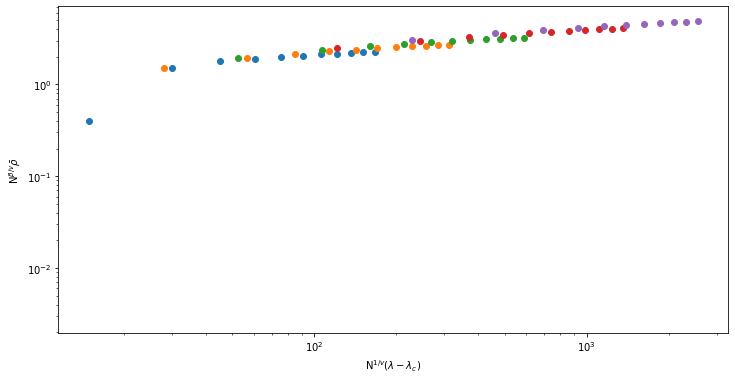

In [50]:
def finite_scaling(datos, figx=None):
    l = datos[2]
    N = datos[3]
    rho = SCA[0]
    
    
    
    for i in range(len(N)):
        x = (l - 3.29355) * (N[i] ** (1 / 1.09684))
        y = rho[i][:] * (N[i] ** (0.27649 / 1.09684))
        #x = l[rho[i][:]>0]
        #y = u4[i][:][rho[i][:]>0]
        
        figx.plot(x, y, 'o')
        figx.set_xscale('log')
        figx.set_yscale('log')
        figx.set_xlabel(r'N$^{1/v}$($\lambda-\lambda_c$)')
        figx.set_ylabel(r'N$^{\beta/v}$$\bar\rho$')
        #figx.set_ylim(0,2)

fig, fig4 = plt.subplots(1, 1, figsize=(12, 6))
    
FSCA = finite_scaling(SCA, figx=fig4) 
plt.savefig('finite_scaling_bib.PNG')


# Densidad en funcion del tiempo: calculo del exponente delta

In [6]:
def funcionsca(x, a, b):
    return a / np.power(x, b)

Comienzo la serie de experimentos
10001 10001
25%
10001 10001
[0.8    0.1595] [[3.34098383e-06 5.20937421e-07]
 [5.20937421e-07 8.39773865e-08]]
50%
10001 10001


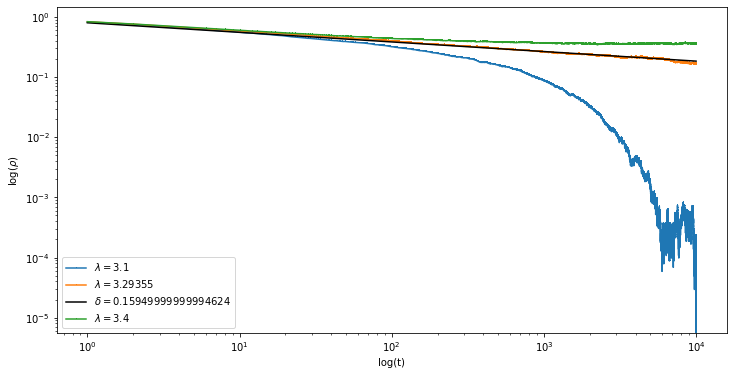

In [9]:
def rhotime(N, T, rep, trials, figx=None):
    prob = [3.1, 3.29355, 3.4]
    rho = np.zeros([trials+1,T+1])
    std = np.zeros(len(prob))
    t = np.linspace(1, T+1, T+1)
    n = np.zeros(T+1)
    X = np.zeros([T+1, N])
    ps = np.zeros(T+1)

    print('Comienzo la serie de experimentos')
    
    for m in range(len(prob)):
        #HAGO LAS ITERACIONES
        #avisos
        if (m == (rep//4)): 
            print('25%')
        if (m == (rep//2)): 
            print('50%')
        if (m == ((3 * rep)//4)): 
            print('75%')
        if (m == (rep-10)):
            print('Acabando experimentos')
        
        for j in range(1, trials + 1, 1):
            #Condicion inicial (lleno)
            dens = np.zeros(T + 1)
            xt = np.ones(N)
            #xt[(N // 2)] = 1
            dens[0] = xt.sum()
            l = prob[m]
            
            #empiezo el CP
            S = proceso(N, T, l, xt, dens)
            X += S[0]
            dens = S[1] / N
            rho[j-1][0:T+1:1] = dens[0:T+1:1]
        
        X = X / trials          

        ps = [np.mean(i) for i in zip(*rho)]
        
        print(len(ps), len(t))
        figx.plot(t, ps, ',-', label=(f'$\lambda={l}$'))

        if (m == 1):
            xf = t
            yf = ps
            fit, fitcov = curve_fit(funcionsca, xf, yf, bounds=([0.80, 0.159400], [0.81, 0.159500]), maxfev=1000)
            afit = fit[0]
            bfit = fit[1]
            yfit = afit / np.power(t,(bfit))
            print(fit, fitcov)
            figx.plot(t, yfit, 'k-', label=(f'$\delta={bfit}$'))
            
    figx.set_xscale('log')
    figx.set_yscale('log')
    figx.set_xlabel('log(t)')
    figx.set_ylabel(r'log($\rho$)')
    figx.legend()
    return rho, t
fig, fig5 = plt.subplots(1, 1, figsize=(12,6))

RHO = rhotime(2000, 10000, 5, 50, figx=fig5)

plt.savefig('densidad_frente_t.PNG')

# Exponente eta y z

20%
40%
60%
80%
Acabando
plot


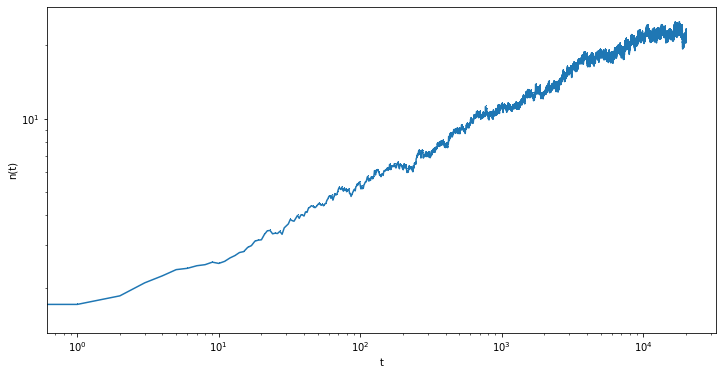

In [18]:
def n_t(N, T, trials):
    fig, fig1 = plt.subplots(1, 1, figsize=(12, 6))
    t = np.linspace(0, T+1, T+1)
    prob = 3.29355
    nt = np.zeros(T+1)
    for i in range(1, trials + 1, 1):
        
        if (i == (trials // 5)):
            print('20%')
        if (i == (2 * trials // 5)):
            print('40%')
        if (i == (3 * trials // 5)):
            print('60%')
        if (i == (4 * trials // 5)):
            print('80%')
        
        ntrial = np.zeros(T+1)
        
        #condicion inicial (seed)
        xt = np.zeros(N)
        xt[N//2] = 1
        
        ntrial[0] = 1
        
        #hago el CP
        S = proceso(N, T, prob, xt, ntrial)
        ntrial = S[1]
        nt += ntrial
    
    print('Acabando')    
    nt = nt / trials
    print('plot')
    fig1.plot(t, nt, ',-')
    fig1.set_xscale('log')
    fig1.set_yscale('log')
    fig1.set_xlabel('t')
    fig1.set_ylabel('n(t)')
    plt.savefig('n_t.PNG')
    
    return nt
    
NT = n_t(2000, 20000, 200)

In [31]:
@jit
def R_trial(x, N, T):
    rtrial = np.zeros(T+1)
    for j in range(T+1):
        for k in range(N):
            r = np.abs((N // 2) - k)
            rtrial[j] += np.power(r, 2) * x[j][k]
    return rtrial

20%
40%
60%
80%
Acabando
plot


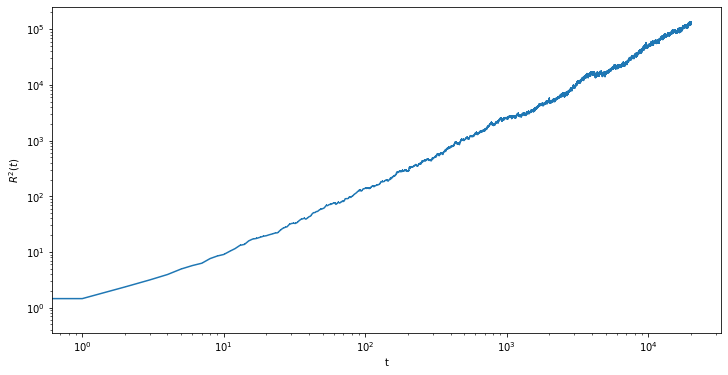

In [64]:
def R_t(N, T, trials):
    fig, fig1 = plt.subplots(1, 1, figsize=(12, 6))
    t = np.linspace(0, T+1, T+1)
    prob = 3.29355
    nt = np.zeros(T+1)
    rt = np.zeros(T+1)
    for i in range(1, trials + 1, 1):
        
        if (i == (trials // 5)):
            print('20%')
        if (i == (2 * trials // 5)):
            print('40%')
        if (i == (3 * trials // 5)):
            print('60%')
        if (i == (4 * trials // 5)):
            print('80%')
        
        ntrial = np.zeros(T+1)
        rtrial = np.zeros(T+1)
        
        #condicion inicial (seed)
        xt = np.zeros(N)
        xt[N//2] = 1
        
        ntrial[0] = 1
        
        #hago el CP
        S = proceso(N, T, prob, xt, ntrial)
        X = S[0]
        ntrial = S[1]
        rtrial = R_trial(X, N, T)
            
        nt += ntrial
        rt += rtrial
    
    print('Acabando')    
    nt = nt / trials
    
    rt = rt / (nt * trials)
    print('plot')
    fig1.plot(t, rt, ',-')
    fig1.set_xscale('log')
    fig1.set_yscale('log')
    fig1.set_xlabel('t')
    fig1.set_ylabel(f'$R^2(t)$')
    plt.savefig('R_t.PNG')
    
    return rt

RT = R_t(2000, 20000, 200)

In [19]:
def nrpow(x, a, b):
    return a * np.power(x, b)

[1.14276895 0.313     ] [[ 1.04981638e-04 -9.84663978e-06]
 [-9.84663978e-06  9.27548781e-07]]


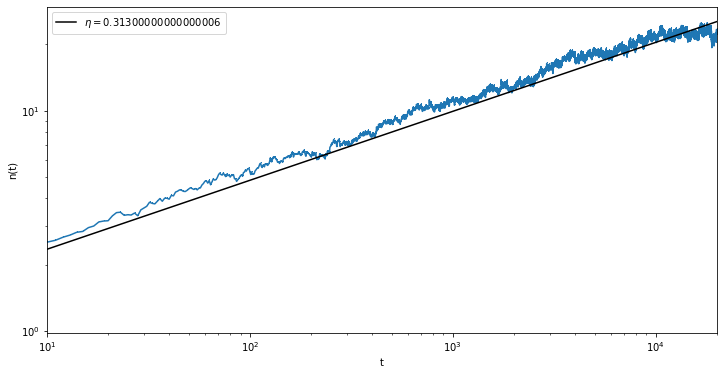

In [66]:
def npow(nt, T):
    fig, fig1 = plt.subplots(1, 1, figsize=(12,6))
    t = np.linspace(0,T+1,T+1)
    
    fit, fitcov = curve_fit(nrpow, t[t>=100], nt[t>=100], bounds=([0, 0.313], [1.5, 0.33]))
    
    print(fit, fitcov)
    
    nfit = nrpow(t, fit[0], fit[1])
    
    fig1.plot(t, nt, ',-')
    fig1.plot(t, nfit, '-k', label=(f'$\eta={fit[1]}$'))
    fig1.set_xscale('log')
    fig1.set_yscale('log')
    fig1.set_xlabel('t')
    fig1.set_ylabel('n(t)')
    fig1.set_xlim(10, 20000)
    fig1.legend()
    plt.savefig('n_power.PNG')
    
npow(NT, 20000)

[0.42864163 1.27      ] [[ 3.84049633e-05 -9.30454490e-06]
 [-9.30454490e-06  2.25619769e-06]]


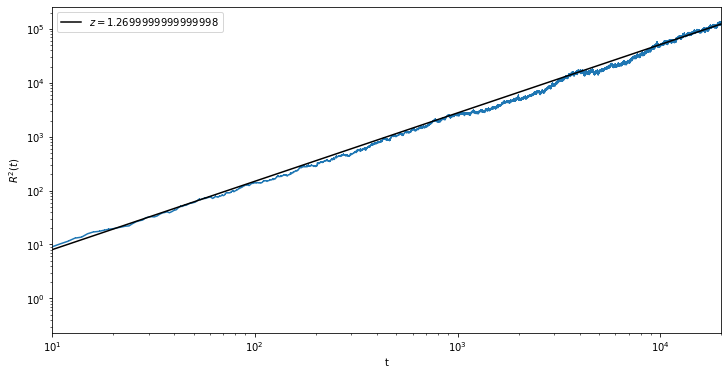

In [67]:
def rpow(rt, T):
    fig, fig1 = plt.subplots(1, 1, figsize=(12,6))
    t = np.linspace(0,T+1,T+1)
    
    fit, fitcov = curve_fit(nrpow, t[t>=100], rt[t>=100], bounds=([0, 1.2000], [1, 1.27000]))
    
    print(fit, fitcov)
    
    rfit = nrpow(t, fit[0], fit[1])
    
    fig1.plot(t, rt, ',-')
    fig1.plot(t, rfit, '-k', label=(f'$z={fit[1]}$'))
    fig1.set_xscale('log')
    fig1.set_yscale('log')
    fig1.set_xlabel('t')
    fig1.set_ylabel(f'$R^2(t)$')
    fig1.set_xlim(10, 20000)
    fig1.legend()
    plt.savefig('r_power.PNG')
    
rpow(RT, 20000)